# Scraping Top Repositories for Topics on Github

## TODO:
- Intro about web scraping
- Intro about Github and the problem statement
- Mention the tools I use (Python, requests, BeautifulSoup, Pandas)

## Here are the steps we'll follow:
- We're going to scrape https://github.com/topics
- We'll get a list of topics. For each topic, we'll get topic title, topic page URL and topic description
- For each topic, we'll get the top 25 repositories in the topic from the topic page
- For each repository, we'll grab the repo name, username, stars and repo URL
- For each topic we'll create a CSV file in the following format:\
Repo Name,Username,Stars,Repo URL \
three.js,mrdoob,69700,https://github.com/mrdoob/three.js \
libgdx,libgdx,18300,https://github.com/libgdx/libgdx

## Scrape the list of topics from Github：
- use requests to downlaod the page
- user BS4 to parse and extract information
- convert to a Pandas dataframe

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

In [2]:
def scrape_topics():
    # Download page
    base_url = 'https://github.com/topics'
    response = requests.get(base_url)
    
    # Check successful response
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(base_url))
    
    # Parse using Beautiful Soup
    doc = BeautifulSoup(response.text, 'html.parser')
    
    # Get info
    topic_dict = {'title':get_topic_titles_url(doc, base_url)[0],
              'descriptions':get_topic_desc(doc),
              'url':get_topic_titles_url(doc, base_url)[1]}
    
    return pd.DataFrame(topic_dict)

In [3]:
def get_topic_titles_url(doc, base_url): 
    selection_class = 'f3 lh-condensed mb-0 mt-1 Link--primary'
    topic_title_tags = doc.find_all('p', {'class':selection_class})
    
    topic_titles = []
    for tag in topic_title_tags:
        topic_titles.append(tag.text)
    
    topic_urls = []
    for tag in topic_title_tags:
        topic_urls.append(base_url + tag.parent['href'])
    
    return topic_titles, topic_urls

def get_topic_desc(doc):
    desc_selector = 'f5 color-fg-muted mb-0 mt-1'
    topic_desc_tags = doc.find_all('p',{'class':desc_selector})
    
    topic_descriptions = []
    for tag in topic_desc_tags:
        topic_descriptions.append(tag.text.strip())

## Get the top 25 repositories from a topic page

In [4]:
def get_topic_doc(topic_url):
    # Download page 
    response = requests.get(topic_url)
    
    # Check successful response
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    
    # Parse using Beautiful Soup
    topic_doc = BeautifulSoup(response.text, 'html.parser')
    
    return topic_doc

In [5]:
def parse_star_count(star_tag):
    stars_str = star_tag.text.strip()
    if stars_str[-1] == 'k':
        return int(float(stars_str[:-1]) * 1000)
    return int(stars_str)

def get_repo_info(repo_tag, star_tag):
    # return all information about a repo
    a_tags = repo_tag.find_all('a')
    username = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url = base_url + a_tags[1]['href']
    stars = parse_star_count(star_tag)
    
    return username, repo_name, stars, repo_url

def get_topic_repos(topic_doc):  
    # Get the h3 tags containing repo title and username
    h3_selection = 'f3 color-fg-muted text-normal lh-condensed'
    repo_tags = topic_doc.find_all('h3', {'class':h3_selection})
    
    # Get star tags
    start_selection = 'Counter js-social-count'
    star_tags = topic_doc.find_all('span', {'class':a_selection})
    
    # Get repo info
    topic_repos_dict = {
    'username':[],
    'repo_name':[],
    'stars':[],
    'repo_url':[]
    }

    for i in range(len(repo_tags)):
        repo_info = get_repo_info(repo_tags[i], star_tags[i])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
    
    return pd.DataFrame(topic_repos_dict)

In [6]:
def scrape_topic(path, topic_url):
    if os.path.exists(path):
        print("The file already exists. Skipping...")
        return
    topic_df = get_topic_repos(get_topic_doc(topic_url))
    topic_df.to_csv(path, index=None)

## Put all functions above in the following functions

In [7]:
def scrape_topics_repo():
    print('Scraping top topic repo from github')
    topics_df = scrape_topics()
    print('------------------------------------')
    
    os.makedirs('repo_data', exist_ok=True)
    
    for index, row in topics_df.iterrows():
        print('Scraping top repo for {}...'.format(row['title']))
        scrape_topic('repo_data/' + row['title'] + '.csv', row['url'])
    print("All done!")

In [8]:
scrape_topics_repo()

Scraping top topic repo from github
------------------------------------
Scraping top repo for 3D...
The file already exists. Skipping...
Scraping top repo for Ajax...
The file already exists. Skipping...
Scraping top repo for Algorithm...
The file already exists. Skipping...
Scraping top repo for Amp...
The file already exists. Skipping...
Scraping top repo for Android...
The file already exists. Skipping...
Scraping top repo for Angular...
The file already exists. Skipping...
Scraping top repo for Ansible...
The file already exists. Skipping...
Scraping top repo for API...
The file already exists. Skipping...
Scraping top repo for Arduino...
The file already exists. Skipping...
Scraping top repo for ASP.NET...
The file already exists. Skipping...
Scraping top repo for Atom...
The file already exists. Skipping...
Scraping top repo for Awesome Lists...
The file already exists. Skipping...
Scraping top repo for Amazon Web Services...
The file already exists. Skipping...
Scraping top rep

## Results displayed: take topic "3D" as an example

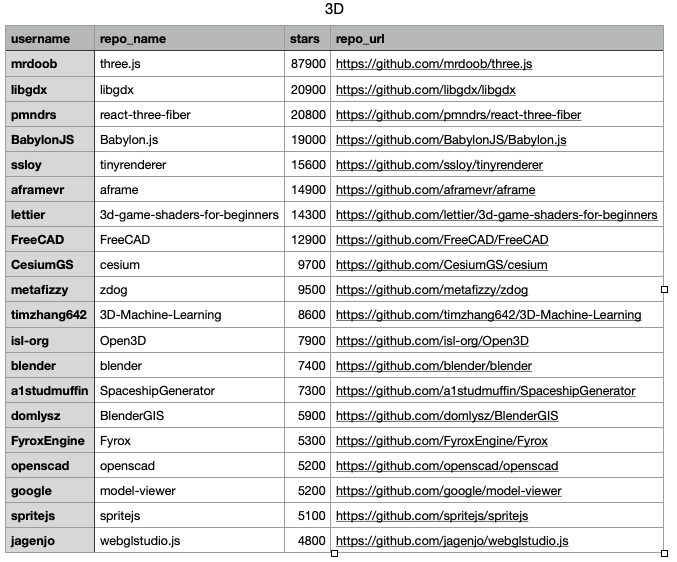

## References:
https://www.youtube.com/watch?v=RKsLLG-bzEY

## Summary:
- This is a beginner-freindly web scraping project
- I don't scrape all topics and all repos on github, I just scraped all information in one page

## Future work:
- Try to scrape information on multiple pages
- Try to scrape websites that need user logging